In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## SKIP THIS PART
# Ploomber related variables
upstream = None
product = None

In [ ]:
# Parameters
mlflow_tracking_uri = "http://127.0.0.1:5000"
experiment_name = "classification"
train_size = 0.8
fix_imbalance = True
numeric_imputation = "median"
include_models = ["lightgbm", "lr", "rf"]
upstream = {"feature_generation": {"nb": "C:\\Users\\berkayg\\Desktop\\Coding env\\ test-case\\products\\feature_generation_nb.ipynb", "data": "C:\\Users\\berkayg\\Desktop\\Coding env\\ test-case\\products\\processed_train_data.csv"}}
product = {"nb": "C:\\Users\\berkayg\\Desktop\\Coding env\\ test-case\\products\\train_model.ipynb", "config": "C:\\Users\\berkayg\\Desktop\\Coding env\\ test-case\\products\\config.pkl"}


# Model Training

In [4]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from src.data.database_configurations import *
import mlflow

In [5]:
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [6]:
conn = connect_db()

In [7]:
# Read the cleaned and feature engineered train data
df = pd.read_csv(upstream['feature_generation']['data'])
df.drop(columns=["userid", "currentbugroupname"], inplace=True)
df["search_count"] = df["search_count"].fillna(0)

In [9]:
df.head()

,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count
0,0,Bayan,39.0,85,0.0,0.0,0.0,0.0,0.0
1,1,Bayan,39.0,85,0.0,33.0,0.0,0.0,0.0
2,0,Bayan,39.0,85,0.0,4.0,0.0,0.0,0.0
3,0,Bayan,39.0,85,0.0,6.0,0.0,0.0,0.0
4,0,Bayan,39.0,85,0.0,1.0,0.0,0.0,0.0


In [39]:
# Instantiate PyCaret classifier
clf = setup(data=df,
            target='y',
            train_size = train_size,
            fold = 10,
            html = True,
            silent = True,
            log_plots = True,
            experiment_name = experiment_name,
            log_experiment = True,
            normalize=True, bin_numeric_features=["age"],
            fix_imbalance=True,
            session_id=1)

# Save setup configurations
save_config(product['config'])
mlflow.log_artifact(product['config'])

,Description,Value
0,session_id,1
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(216600, 9)"
5,Missing Values,True
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:
# Run all the model and compare across different metrics (KNN method is removed due to being a overly exhaustive model)
best = compare_models(exclude=["knn"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8860,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0220
catboost,CatBoost Classifier,0.8828,0.6417,0.0604,0.4058,0.1051,0.0779,0.1206,28.9390
xgboost,Extreme Gradient Boosting,0.8659,0.6627,0.1397,0.3068,0.1916,0.1296,0.1418,12.8690
lightgbm,Light Gradient Boosting Machine,0.8484,0.6848,0.2267,0.2896,0.2542,0.1712,0.1729,3.4610
svm,SVM - Linear Kernel,0.8347,0.0000,0.3318,0.2985,0.3138,0.2203,0.2209,2.5550
dt,Decision Tree Classifier,0.8301,0.4774,0.2037,0.2270,0.2147,0.1197,0.1200,2.9510
rf,Random Forest Classifier,0.8286,0.6169,0.2139,0.2298,0.2215,0.1254,0.1255,15.2830
et,Extra Trees Classifier,0.8269,0.6151,0.2222,0.2308,0.2263,0.1289,0.1290,23.9300
ridge,Ridge Classifier,0.8125,0.0000,0.3692,0.2668,0.3098,0.2045,0.2081,2.0470
lda,Linear Discriminant Analysis,0.8124,0.6934,0.3692,0.2668,0.3097,0.2045,0.2081,2.5620


In [41]:
ada_boost = create_model("ada")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6829,0.7177,0.6466,0.2102,0.3173,0.1755,0.2225
1,0.6751,0.7128,0.6420,0.2048,0.3106,0.1665,0.2131
2,0.6788,0.7282,0.6648,0.2112,0.3206,0.1785,0.2289
3,0.6681,0.7213,0.6592,0.2041,0.3117,0.1666,0.2164
4,0.6752,0.7239,0.6501,0.2064,0.3133,0.1696,0.2176
5,0.6872,0.7146,0.6294,0.2095,0.3144,0.1730,0.2170
6,0.6909,0.7095,0.6127,0.2086,0.3112,0.1701,0.2112
7,0.6990,0.7205,0.6228,0.2158,0.3205,0.1820,0.2243
8,0.6712,0.7141,0.6441,0.2030,0.3087,0.1637,0.2108


In [27]:
final_model = finalize_model(tune_model(ada_boost, choose_better = True, optimize = 'AUC'))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5712,0.6503,0.7528,0.1766,0.2861,0.1242,0.1912
1,0.5700,0.6553,0.7659,0.1782,0.2891,0.1275,0.1976
2,0.5678,0.6508,0.7583,0.1762,0.2860,0.1236,0.1918
3,0.5702,0.6570,0.7696,0.1789,0.2903,0.1288,0.1998
4,0.5735,0.6604,0.7731,0.1806,0.2928,0.1321,0.2041
5,0.5721,0.6590,0.7716,0.1799,0.2917,0.1307,0.2023
6,0.5740,0.6612,0.7741,0.1809,0.2933,0.1328,0.2051
7,0.5732,0.6537,0.7580,0.1782,0.2886,0.1272,0.1956
8,0.5653,0.6532,0.7671,0.1767,0.2873,0.1248,0.1949


In [28]:
final_model

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1e-06,
                   n_estimators=80, random_state=1)

In [29]:
save_model(final_model, 'classification')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='y',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                 ('dummy', Dummify(target='y')),
                 ('fix_perfect', Remove_100(target='y')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'pass

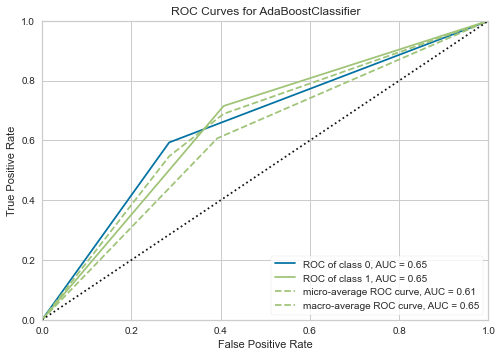

In [45]:
plot_model(final_model, plot = 'auc')

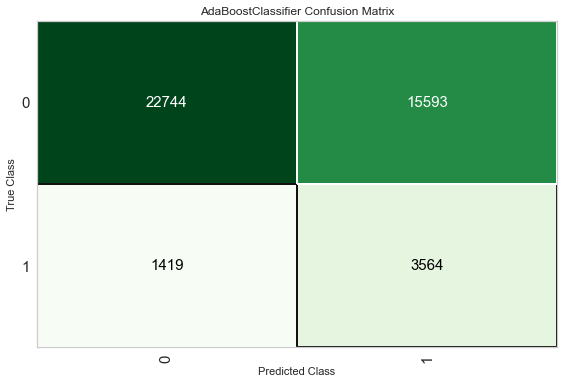

In [46]:
plot_model(final_model, plot = 'confusion_matrix')